# Libraries

In [38]:
# Libraries
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from scipy.sparse import csr_matrix, hstack

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

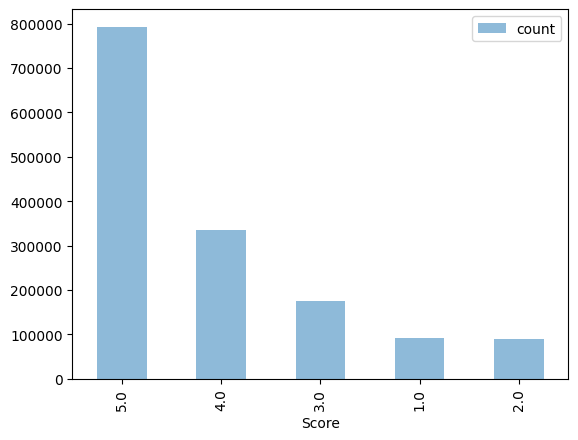


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [39]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Preprocessing

In [43]:
# Preprocessing and feature engineering
def preprocess_data(df, is_training=True):
    print(f"Preprocessing data (Training: {is_training})...")
    
    # Drop rows where 'Score' is missing for training data only
    if is_training:
        df = df.dropna(subset=['Score'])
        df['Score'] = df['Score'].astype(int)  # Ensure 'Score' column is int
    
    # Drop 'Id' if present to avoid affecting the model
    if 'Id' in df.columns:
        df = df.drop(columns=['Id'])
    
    # Handle text data for TF-IDF (only if 'Text' is in the columns)
    if 'Text' in df.columns:
        # Fill NaN values in 'Text' with an empty string
        df['Text'] = df['Text'].fillna("")
        print("Applying TF-IDF transformation...")
        tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
        text_features = tfidf.fit_transform(df['Text']).toarray() if is_training else tfidf.transform(df['Text']).toarray()
        df = pd.concat([df.drop(columns=['Text']), pd.DataFrame(text_features)], axis=1)
    
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print(f"Standardizing numerical columns: {list(numerical_cols)}")
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

# Adding Features

In [41]:
# Feature engineering function with label encoding for categorical columns
def add_features_to(df):
    # Create a helpfulness score from the helpfulness columns
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Encoding non-numeric columns except 'Text' and 'Summary'
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    for col in non_numeric_cols:
        if col not in ['Text', 'Summary']:
            label_enc = LabelEncoder()
            df[col] = label_enc.fit_transform(df[col].astype(str))
    return df

# Check if preprocessed files exist; if not, preprocess and save them
if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Apply feature engineering to training data
    train = add_features_to(trainingSet)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, on='Id', how='inner')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # Separate training data with non-null 'Score'
    X_train = train[train['Score'].notnull()]

    # Save preprocessed data
    X_train.to_csv("./data/X_train.csv", index=False)
    X_submission.to_csv("./data/X_submission.csv", index=False)

    print("X_train columns:", X_train.columns)
    print("X_submission columns:", X_submission.columns)

# Sample + Split into training and testing set

In [44]:
# Split training set into train and test sets
X_train = preprocess_data(X_train)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=0.25,
    random_state=0
)

Preprocessing data (Training: True)...
Applying TF-IDF transformation...


MemoryError: Unable to allocate 55.3 GiB for an array with shape (1485341, 5000) and data type float64

# Feature Selection

In [21]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [22]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.40944319968976883


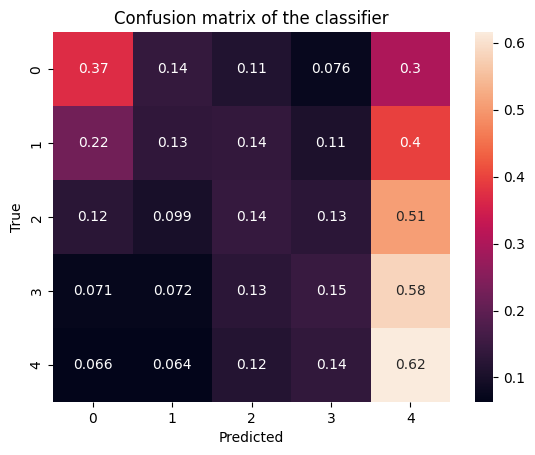

In [23]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Random Forest Model
def train_and_evaluate(X_train, X_test, y_train, y_test):
    print("Training Random Forest model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    return model

# Create submission file

In [24]:
# Prepare data for the final submission
def create_submission(model, test_filepath):
    print("Creating submission file...")
    test_df = pd.read_csv(test_filepath)
    test_df = add_features_to(test_df)  # Apply feature engineering
    test_df_processed = preprocess_data(test_df, is_training=False)  # Preprocess without 'Score'
    X_submission = test_df_processed.drop(columns=['Score'], errors='ignore')
    test_df['Score'] = model.predict(X_submission)
    submission = test_df[['Id', 'Score']]
    submission.to_csv("./data/submission.csv", index=False)
    print("Submission file created at './data/submission.csv'")

# Train model and create submission
rf_model = train_and_evaluate(X_train, X_test, Y_train, Y_test)
create_submission(rf_model, "./data/test.csv")


Splitting data into training and testing sets...


KeyError: "The 'Score' column is missing from the dataframe."